In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
pd.options.mode.chained_assignment = None  # default='warn

# import data
df = pd.read_csv('./datasets/home-credit-default-risk/application_train.csv')
print(df.shape)

# get numeric cols
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_df = df.select_dtypes(include=numerics)
print(num_df.shape)

# get categorical cols
categorical = [df[col].dtype for col in df.columns if df[col].dtype not in numerics]
categorical_df = df.select_dtypes(include=categorical)
print(categorical_df.shape)

(307511, 122)
(307511, 106)
(307511, 16)


In [2]:
# fix Nan's in numerical data
for col in num_df.columns:
    if num_df[col].isnull().sum() > 0:
        num_df[col].fillna(num_df[col].mean(), inplace=True)

In [3]:
# convert categorical variables to numbers
categorical_df = categorical_df.apply(lambda x: x.factorize()[0])

In [4]:
# recombine numerical and categorical cols into single dataframe
cleaned_df = pd.concat([num_df, categorical_df], axis=1)

In [5]:
def rm_low_var(df, var_thresh=0):
    var_filter = VarianceThreshold(threshold=var_thresh)
    var_filter.fit(df)
    low_var_cols_size = len(df.columns[var_filter.get_support()])
    
    print('Removing {} cols'.format(df.shape[-1] - low_var_cols_size))
    cols_to_remove = [col for col in df.columns if col not in df.columns[var_filter.get_support()]]
    df.drop(labels=cols_to_remove, axis=1, inplace=True)
    return df

# identify columns with zero variance - ie constant features
cleaned_df = rm_low_var(cleaned_df, 0)

# identify columns where most of the values are the same
cleaned_df = rm_low_var(cleaned_df, 0.01)

print(cleaned_df.shape)

Removing 0 cols
Removing 60 cols
(307511, 62)


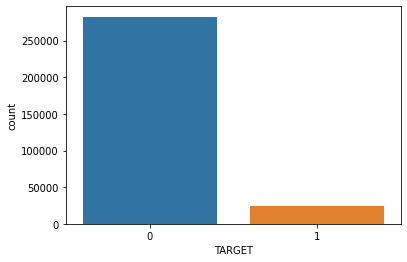

In [6]:
# plot target variable to check for data imbalances
sns.countplot(x="TARGET", data=cleaned_df)
plt.show()

In [7]:
# remove highly correlated features
correlated_features = set()
correlation_matrix = cleaned_df.corr()
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            

print('Removing {} cols'.format(len(correlated_features)))
cleaned_df.drop(labels=correlated_features, axis=1, inplace=True)
cleaned_df.shape

Removing 11 cols


(307511, 51)

In [8]:
# find features that are correlated with target
corr_matrix = cleaned_df.corr()
target_correlated = corr_matrix['TARGET'].sort_values(ascending=False).to_dict()
top_ten = [k for (k,v) in sorted(target_correlated.items(), key=lambda x: abs(x[1]), reverse=True)][1: 11]
top_ten

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'DAYS_BIRTH',
 'REGION_RATING_CLIENT',
 'NAME_INCOME_TYPE',
 'DAYS_LAST_PHONE_CHANGE',
 'CODE_GENDER',
 'DAYS_ID_PUBLISH',
 'REG_CITY_NOT_WORK_CITY']

In [9]:
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_sample(cleaned_df, cleaned_df['TARGET'])
np.unique(y_res, return_counts=True)
balanced_df = pd.DataFrame(X_res, columns=cleaned_df.columns, index=cleaned_df.index)

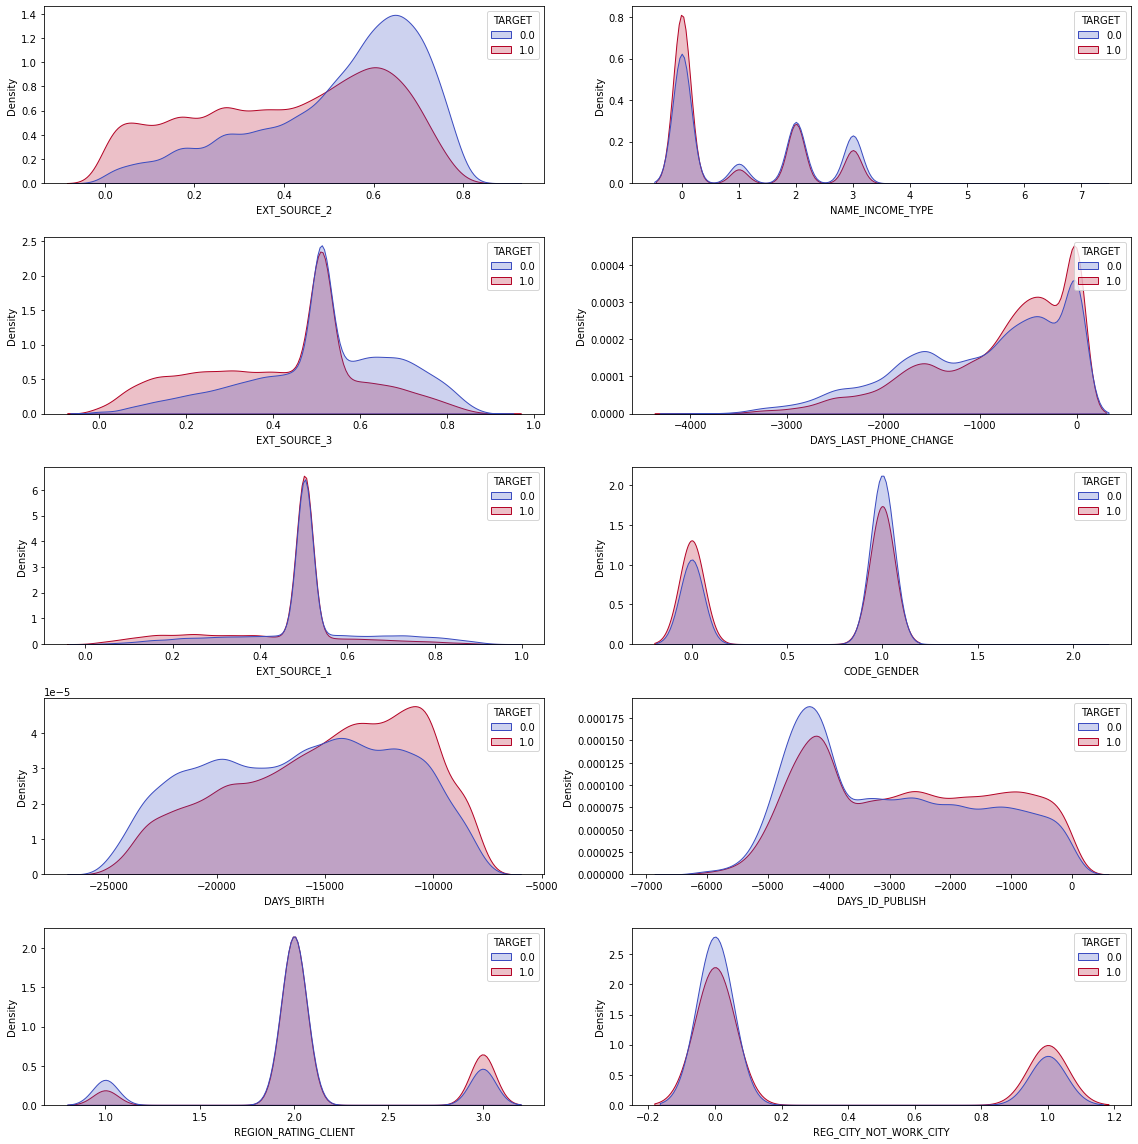

In [28]:
# numerical plots based on correlation of feature with target
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,16))
col_idx = 0
for idx, col in enumerate(top_ten):
    row_idx = 0 if idx < 5 else 1    
    col_idx = 0 if idx == 5 else col_idx
    sns.kdeplot(data=balanced_df, x=col, hue="TARGET", ax=axs[col_idx, row_idx], palette='coolwarm', fill=True)
    col_idx += 1
plt.tight_layout()
plt.show()

In [11]:
# select 10 best features based on top chi-squared scores with target variable
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X = cleaned_df[[col for col in cleaned_df.columns if col != 'TARGET']]
y = cleaned_df['TARGET']
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=10)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(chi_feature)

['DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_DOCUMENT_6', 'NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE']


In [12]:
# categorical feautures chosen
best_cat_cols = [col for col in categorical_df.columns if col in chi_feature]

In [13]:
# numerical feautures chosen
best_num_cols = [col for col in num_df.columns if col in chi_feature]

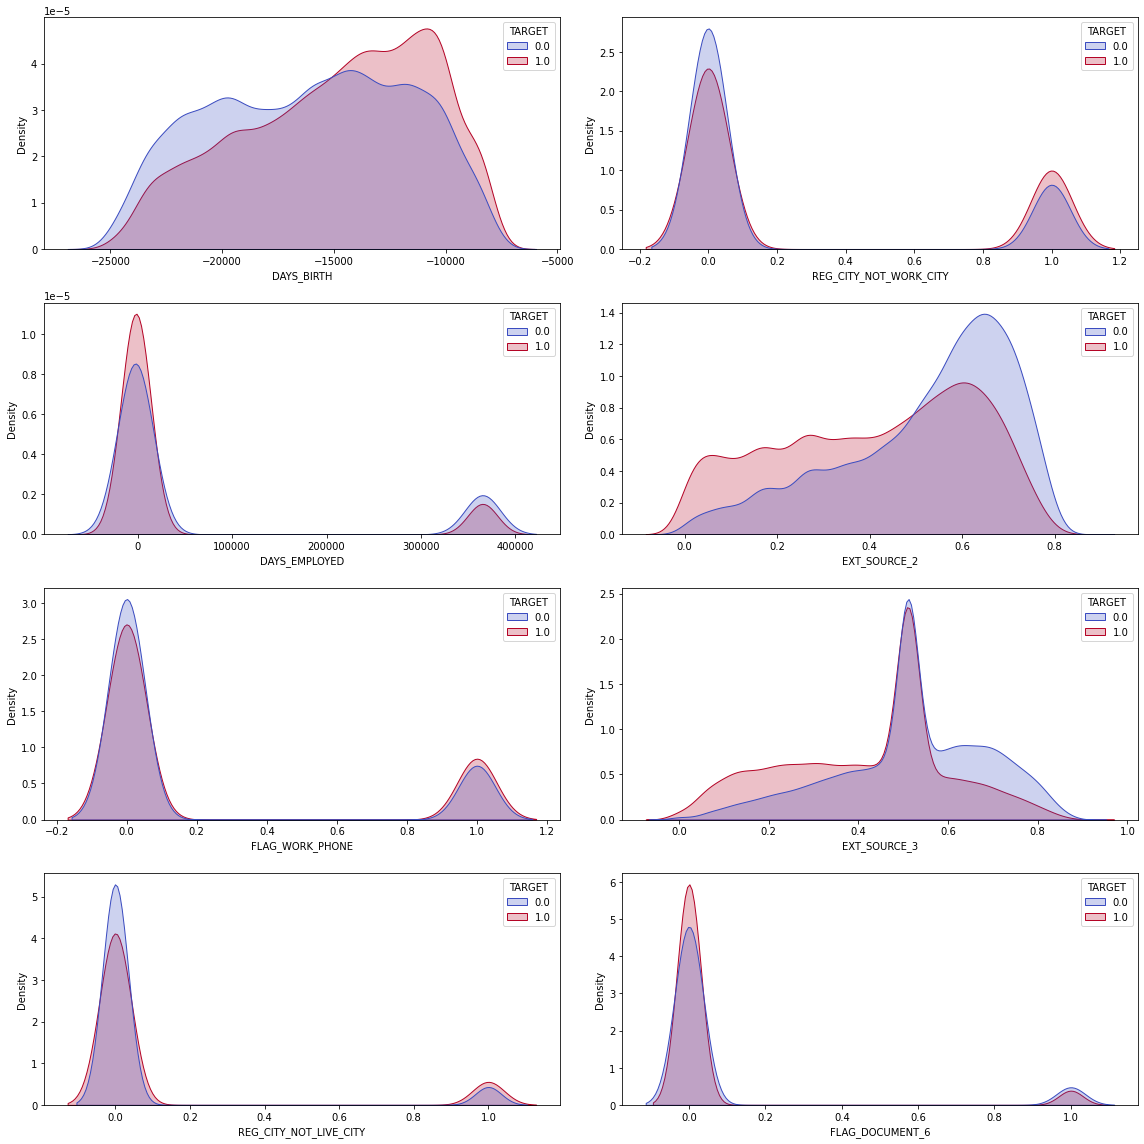

In [25]:
# plot densities of numerical data chosed by chi 
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16,16))
col_idx = 0
for idx, col in enumerate(best_num_cols):
    row_idx = 0 if idx < 4 else 1    
    col_idx = 0 if idx == 4 else col_idx
    sns.kdeplot(data=balanced_df, x=col, hue="TARGET", ax=axs[col_idx, row_idx], palette="coolwarm", fill=True)
    col_idx += 1
plt.tight_layout()
plt.show()

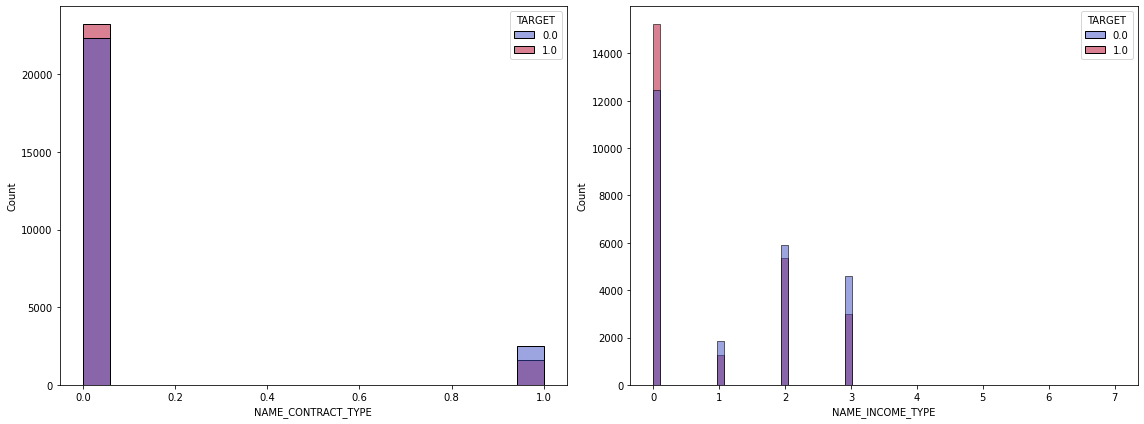

In [32]:
fig, axs = plt.subplots(ncols=2, figsize=(16,6))
sns.histplot(data=balanced_df, x=best_cat_cols[0], hue="TARGET", multiple="layer", ax=axs[0], palette="coolwarm")
sns.histplot(data=balanced_df, x=best_cat_cols[1], hue="TARGET", multiple="layer", ax=axs[1], palette="coolwarm")
plt.tight_layout()
plt.show()

### Conclusion

Altough correlation matrix found some important features, plotting revelaed very little difference in distributions based on target labels.  Best 10 features are based on chi-squared correlation tests which appear to yield better distrubtion differences.

 1.  DAYS_BIRTH
 2.  DAYS_EMPLOYED
 3.  FLAG_WORK_PHONE 
 4.  REG_CITY_NOT_LIVE_CITY
 5.  REG_CITY_NOT_WORK_CITY
 6.  EXT_SOURCE_2
 7.  EXT_SOURCE_3
 8.  FLAG_DOCUMENT_6
 9.  NAME_CONTRACT_TYPE
 10. NAME_INCOME_TYPE